### データの結合および加工

In [2]:
# 個人のデータを結合

import json
anno_id1_detect_json_open = open("./dataset/annotation_data/anno_id1_region_danger_info_data.json", 'r',encoding="utf-8_sig")
anno_id1_detect_json_load = json.load(anno_id1_detect_json_open)
print("anno_id1のデータ件数は",len(anno_id1_detect_json_load))

anno_id2_detect_json_open = open("./dataset/annotation_data/anno_id2_region_danger_info_data.json", 'r',encoding="utf-8_sig")
anno_id2_detect_json_load = json.load(anno_id2_detect_json_open)
print("anno_id2のデータ件数は",len(anno_id2_detect_json_load))

anno_id3_detect_json_open = open("./dataset/annotation_data/anno_id3_region_danger_info_data.json", 'r',encoding="utf-8_sig")
anno_id3_detect_json_load = json.load(anno_id3_detect_json_open)
print("anno_id3のデータ件数は",len(anno_id3_detect_json_load))

anno_id3_2_detect_json_open = open("./dataset/annotation_data/anno_id3_2_region_danger_info_data.json", 'r',encoding="utf-8_sig")
anno_id3_2_detect_json_load = json.load(anno_id3_2_detect_json_open)
print("anno_id3_2のデータ件数は",len(anno_id3_2_detect_json_load))

anno_id4_detect_json_open = open("./dataset/annotation_data/anno_id4_region_danger_info_data.json", 'r',encoding="utf-8_sig")
anno_id4_detect_json_load = json.load(anno_id4_detect_json_open)
print("anno_id4のデータ件数は",len(anno_id4_detect_json_load))

anno_id4_2_detect_json_open = open("./dataset/annotation_data/anno_id4_2_region_danger_info_data.json", 'r',encoding="utf-8_sig")
anno_id4_2_detect_json_load = json.load(anno_id4_2_detect_json_open)
print("anno_id4_2のデータ件数は",len(anno_id4_2_detect_json_load))

anno_id1のデータ件数は 809
anno_id2のデータ件数は 331
anno_id3のデータ件数は 121
anno_id3_2のデータ件数は 212
anno_id4のデータ件数は 299
anno_id4_2のデータ件数は 393


In [4]:
all_data = anno_id1_detect_json_load + anno_id2_detect_json_load + anno_id3_detect_json_load + anno_id3_2_detect_json_load + anno_id4_detect_json_load + anno_id4_2_detect_json_load
print("結合後のデータ数は", len(all_data))

結合後のデータ数は 2165


In [7]:
# "id"キーの値を使ってリストをソート
sorted_all_data = sorted(all_data, key=lambda x: x["id"])

In [8]:
# すべてのboxの位置情報を左上と右下の座標に変換(アノテーション時にboxの始点と終点が異なるためそろえる)

def convert_to_corners(coord1, coord2):
    # 与えられた2つの座標を左上と右下に変換する処理
    x1, y1 = coord1
    x2, y2 = coord2
    
    left = min(x1, x2)
    top = min(y1, y2)
    right = max(x1, x2)
    bottom = max(y1, y2)
    
    return [left, top, right, bottom]

# 与えられた座標
for i, one_image_data in enumerate(sorted_all_data):

    for d, one_box_data in enumerate(one_image_data["regions"]):
        x1y1 = [one_box_data["boxes"][0],one_box_data["boxes"][1]]
        x2y2 = [one_box_data["boxes"][2],one_box_data["boxes"][3]]

        sorted_all_data[i]["regions"][d]["boxes"] = convert_to_corners(x1y1, x2y2)

In [11]:
# YOLOによる検出データの読み込み
yolo_detect_json_open = open("./dataset/detect_data.json", 'r',encoding="utf-8_sig")
detect_json_load = json.load(yolo_detect_json_open)

In [12]:
def in_anno_box(d_obj_pos, a_one_img):
    bool_list = []
    #print("a")
    for a_one_obj in a_one_img:
        if d_obj_pos[0] >= a_one_obj["boxes"][0] and d_obj_pos[1] >= a_one_obj["boxes"][1] and d_obj_pos[2] >= a_one_obj["boxes"][2] and d_obj_pos[3] >= a_one_obj["boxes"][3]:
            bool_list.append(True)
        else:
            bool_list.append(False)
            
    return bool_list

def find_true_indices(lst):
    return [index for index, value in enumerate(lst) if value is True]

def iou(d_obj_pos, a_one_img):
    # a, bは矩形を表すリストで、a=[xmin, ymin, xmax, ymax]
    iou_list = []
    ax_mn, ay_mn, ax_mx, ay_mx = d_obj_pos[0], d_obj_pos[1], d_obj_pos[2], d_obj_pos[3]
    for a_one_obj in a_one_img:
        bx_mn, by_mn, bx_mx, by_mx = a_one_obj["boxes"][0], a_one_obj["boxes"][1], a_one_obj["boxes"][2], a_one_obj["boxes"][3]

        a_area = (ax_mx - ax_mn + 1) * (ay_mx - ay_mn + 1)
        b_area = (bx_mx - bx_mn + 1) * (by_mx - by_mn + 1)

        abx_mn = max(ax_mn, bx_mn)
        aby_mn = max(ay_mn, by_mn)
        abx_mx = min(ax_mx, bx_mx)
        aby_mx = min(ay_mx, by_mx)
        w = max(0, abx_mx - abx_mn + 1)
        h = max(0, aby_mx - aby_mn + 1)
        intersect = w*h

        iou = intersect / (a_area + b_area - intersect)
        iou_list.append(iou)
        #print(iou)
    return iou_list

In [13]:
for k,v in detect_json_load.items():#画像枚数分の繰り返し
    
    for anno_one_img in sorted_all_data:#画像枚数分の繰り返し
        if int(k) == int(anno_one_img["id"]):
           for i, detect_one_obj in enumerate(v):
               #print(detect_one_obj)
               one_detect_box_iou_list = iou(detect_one_obj[0], anno_one_img["regions"])
               for u in range(len(one_detect_box_iou_list)):
                    if one_detect_box_iou_list[u] <= 0.1:
                        one_detect_box_iou_list[u] = 0
               non_zero_indices = [i for i, x in enumerate(one_detect_box_iou_list) if x != 0]
               
               if len(non_zero_indices) > 1:
                   non_zero_indices = [max(range(len(one_detect_box_iou_list)), key=one_detect_box_iou_list.__getitem__)]
                           
               img_id = str(k)
               if len(non_zero_indices) == 0:
                   
                   detect_json_load[img_id][i].append("[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]")
               else:
                   detect_json_load[img_id][i].append(anno_one_img["regions"][non_zero_indices[0]]['Danger_item'])
print(detect_json_load)       

{'1': [[[707.0, 202.0, 1000.0, 736.0], 0.7529627680778503, 1, '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]'], [[402.0, 375.0, 426.0, 453.0], 0.6277643442153931, 0, '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]']], '10': [[[550.0, 384.0, 589.0, 502.0], 0.7884036302566528, 0, '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]'], [[618.0, 384.0, 661.0, 506.0], 0.7632228136062622, 0, '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]']], '100': [[[540.0, 368.0, 571.0, 458.0], 0.685330867767334, 0, '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]']], '1000': [[[686.0, 406.0, 862.0, 543.0], 0.9114452004432678, 1], [[436.0, 393.0, 537.0, 484.0], 0.7212439775466919, 1], [[621.0, 347.0, 738.0, 479.0], 0.696910560131073, 3], [[577.0, 384.0, 623.0, 442.0], 0.669811487197876, 1]], '10000': [[[434.0, 418.0, 555.0, 528.0], 0.8891507983207703, 1], [[357.0, 413.0, 418.0, 468.0], 0.8463727831840515, 1], [[773.0, 416.0, 891.0, 467.0], 0.7906094193458557, 1], [[418.0, 411.0, 453.0,

In [14]:
dataset = {}
detect_json_load_copy = detect_json_load.copy()
for k,one_img_data in detect_json_load_copy.items():
    #print("a")
    #print(one_img_data)
    if len(one_img_data[0]) == 4:
        one_img_region_data = []
        for one_box_data_ind in range(len(one_img_data)):
            one_img_region_data.append({"image_id":k, "xyxy":one_img_data[one_box_data_ind][0], "conf":one_img_data[one_box_data_ind][1], "class":one_img_data[one_box_data_ind][2], "risk_focter":one_img_data[one_box_data_ind][3]})
        dataset[k] = one_img_region_data

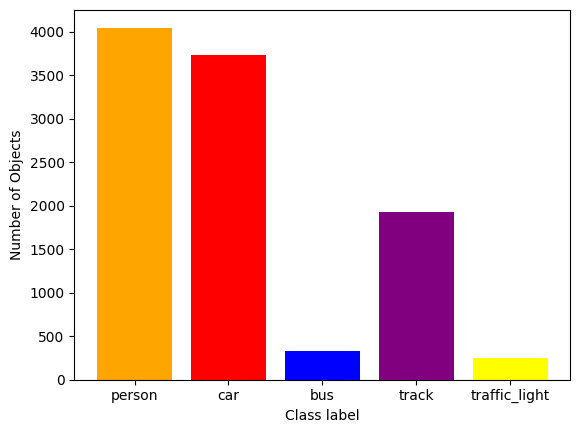

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# perspn:0 car:1 bus:2 track:3 light:4

class_list = [0,0,0,0,0]

for one_data in dataset.values():
    
    for one_region_id in range(len(one_data)):
        class_label = one_data[one_region_id]["class"]
        if class_label == 0:
            class_list[0] += 1
        if class_label == 1:
            class_list[1] += 1
        if class_label == 2:
            class_list[2] += 1
        if class_label == 3:
            class_list[3] += 1
        if class_label == 4:
            class_list[4] += 1

height1 = np.array(class_list)

left = np.arange(0, 5)

plt.ylabel("Number of Objects")
plt.xlabel("Class label")

labels = ['person', 'car', "bus", "track", "traffic_light"]

colors = ["orange", "red", "blue", "purple", "yellow"]

plt.bar(left, height1, color=colors, tick_label = labels)

plt.savefig("./graph_img/class_data_rate.png", format="png", dpi=300)

pn_list [3735, 6543]
物体数は 10278
2.2840696117804553


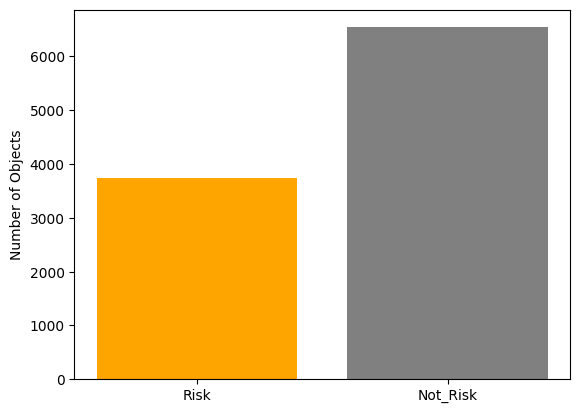

In [17]:
import numpy as np
import matplotlib.pyplot as plt

danger_item_list = []
for one_data in dataset.values():
    
    for one_region_id in range(len(one_data)):
        danger_item = one_data[one_region_id]["risk_focter"]
        danger_item_list.append(eval(danger_item))

pn_list = [0,0]
lisk_factor_num_list = []

for one_danger_item in danger_item_list:
    if one_danger_item != []:
        if all(element == 0 for element in one_danger_item):
            pn_list[1] += 1
            
        else:
            pn_list[0] += 1
            count_of_ones = [1 for element in one_danger_item if element == 1].count(1)
            lisk_factor_num_list.append(count_of_ones)
            
print("pn_list",pn_list)

print("物体数は", len(danger_item_list))
print(np.mean(lisk_factor_num_list))
height1 = np.array(pn_list)

#left = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
left = np.arange(0, 2)

plt.ylabel("Number of Objects")

labels = ['Risk', 'Not_Risk']

colors = ["orange", "grey"]

plt.bar(left, height1, color=colors, tick_label = labels)

plt.savefig("./graph_img/pn_data_rate.png", format="png", dpi=300)

neg_list [10091, 10263, 10267, 10001, 9913, 10264, 10253, 10266, 9892, 8466, 8644, 8866, 10097, 9287, 10158, 10081, 9386]
pos_list [187, 15, 11, 277, 365, 14, 25, 12, 386, 1812, 1634, 1412, 181, 991, 120, 197, 892]
ラベル数が0のインデックスは[]
物体数は 10278


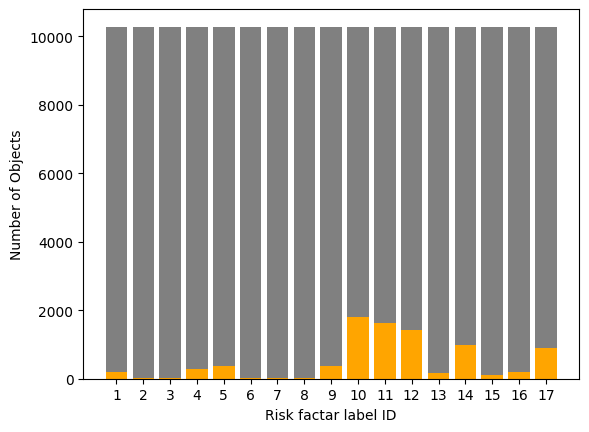

In [18]:
import numpy as np
import matplotlib.pyplot as plt

danger_item_list = []
for one_data in dataset.values():
    
    for one_region_id in range(len(one_data)):
        danger_item = one_data[one_region_id]["risk_focter"]
        danger_item_list.append(eval(danger_item))

class_num = len(danger_item_list[0])

pos_list = (class_num) * [0]
neg_list = (class_num) * [0]

for one_danger_item in danger_item_list:
    if one_danger_item != []:
        
        for class_label in range(class_num):
            if one_danger_item[class_label] == 0:
                neg_list[class_label] += 1
            else:
                pos_list[class_label] += 1
            
print("neg_list",neg_list)
print("pos_list",pos_list)
zero_num_index = [i for i, x in enumerate(pos_list) if x == 0]
print("ラベル数が0のインデックスは" + str(zero_num_index))
print("物体数は", len(danger_item_list))
height1 = np.array(pos_list)
height2 = np.array(neg_list)
labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
left = np.arange(0, len(neg_list))

plt.ylabel("Number of Objects")
plt.xlabel("Risk factar label ID")

plt.bar(left, height1, color="orange", tick_label = labels)
plt.bar(left, height2, bottom=height1, color="grey", tick_label = labels)

plt.savefig("./graph_img/data_rate.png", format="png", dpi=300)

# ラベル数削減

In [19]:
for k,v in dataset.items():#画像枚数分の繰り返し
    for one_box in range(len(v)):
        zip_one_box_risk_factor = [0] * 5
        #対象が侵入している
        if eval(dataset[k][one_box]["risk_focter"])[1] == 1 or eval(dataset[k][one_box]["risk_focter"])[9] == 1 or eval(dataset[k][one_box]["risk_focter"])[5] == 1:
            zip_one_box_risk_factor[0] = 1
        #対象が侵入するかもしれない
        if eval(dataset[k][one_box]["risk_focter"])[2] == 1 or eval(dataset[k][one_box]["risk_focter"])[3] == 1 or eval(dataset[k][one_box]["risk_focter"])[4] == 1 or eval(dataset[k][one_box]["risk_focter"])[6] == 1 or eval(dataset[k][one_box]["risk_focter"])[10] == 1:
            zip_one_box_risk_factor[1] = 1
        #対象が自車に気づいていない
        if eval(dataset[k][one_box]["risk_focter"])[0] == 1 or eval(dataset[k][one_box]["risk_focter"])[11] == 1:
            zip_one_box_risk_factor[2] = 1
        #対象が急停止する、するかもしれない
        if eval(dataset[k][one_box]["risk_focter"])[12] == 1 or eval(dataset[k][one_box]["risk_focter"])[13] == 1:
            zip_one_box_risk_factor[3] = 1
        #対象が進路変更している、するかもしれない
        if eval(dataset[k][one_box]["risk_focter"])[15] == 1 or eval(dataset[k][one_box]["risk_focter"])[16] == 1:
            zip_one_box_risk_factor[4] = 1
            
        dataset[k][one_box]["risk_focter"] = str(zip_one_box_risk_factor)
print(dataset)

{'1': [{'image_id': '1', 'xyxy': [707.0, 202.0, 1000.0, 736.0], 'conf': 0.7529627680778503, 'class': 1, 'risk_focter': '[0, 1, 1, 0, 0]'}, {'image_id': '1', 'xyxy': [402.0, 375.0, 426.0, 453.0], 'conf': 0.6277643442153931, 'class': 0, 'risk_focter': '[0, 1, 0, 0, 0]'}], '10': [{'image_id': '10', 'xyxy': [550.0, 384.0, 589.0, 502.0], 'conf': 0.7884036302566528, 'class': 0, 'risk_focter': '[0, 1, 1, 1, 0]'}, {'image_id': '10', 'xyxy': [618.0, 384.0, 661.0, 506.0], 'conf': 0.7632228136062622, 'class': 0, 'risk_focter': '[0, 1, 1, 1, 0]'}], '100': [{'image_id': '100', 'xyxy': [540.0, 368.0, 571.0, 458.0], 'conf': 0.685330867767334, 'class': 0, 'risk_focter': '[0, 1, 0, 0, 0]'}], '1004': [{'image_id': '1004', 'xyxy': [620.0, 353.0, 769.0, 494.0], 'conf': 0.8942241668701172, 'class': 1, 'risk_focter': '[0, 0, 0, 0, 0]'}, {'image_id': '1004', 'xyxy': [62.0, 373.0, 84.0, 434.0], 'conf': 0.7765676975250244, 'class': 0, 'risk_focter': '[0, 0, 0, 0, 0]'}, {'image_id': '1004', 'xyxy': [129.0, 389.

neg_list [8443, 8506, 8814, 9106, 9189]
pos_list [1835, 1772, 1464, 1172, 1089]
ラベル数が0のインデックスは[]
物体数は 10278


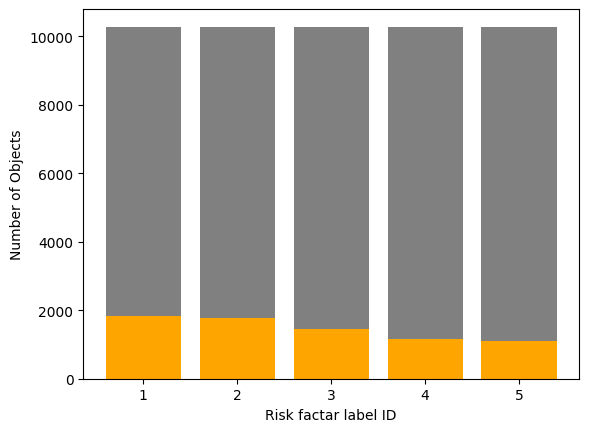

In [20]:
import numpy as np
import matplotlib.pyplot as plt

danger_item_list = []
for one_data in dataset.values():
    
    for one_region_id in range(len(one_data)):
        danger_item = one_data[one_region_id]["risk_focter"]
        danger_item_list.append(eval(danger_item))

class_num = len(danger_item_list[0])

pos_list = (class_num) * [0]
neg_list = (class_num) * [0]

for one_danger_item in danger_item_list:
    if one_danger_item != []:
        
        for class_label in range(class_num):
            if one_danger_item[class_label] == 0:
                neg_list[class_label] += 1
            else:
                pos_list[class_label] += 1
            
print("neg_list",neg_list)
print("pos_list",pos_list)
zero_num_index = [i for i, x in enumerate(pos_list) if x == 0]
print("ラベル数が0のインデックスは" + str(zero_num_index))
print("物体数は", len(danger_item_list))
height1 = np.array(pos_list)
height2 = np.array(neg_list)
labels = [1,2,3,4,5]
left = np.arange(0, len(neg_list))

plt.ylabel("Number of Objects")
plt.xlabel("Risk factar label ID")

plt.bar(left, height1, color="orange", tick_label = labels)
plt.bar(left, height2, bottom=height1, color="grey", tick_label = labels)

plt.savefig("./graph_img/reduce_data_rate.png", format="png", dpi=300)

"""
with open('./dataset/label_reduction_dataset.json', 'w') as fp:
    json.dump(dataset, fp, ensure_ascii=False, indent=2)
"""

# アンダーサンプリング

In [21]:
for k,v in dataset.items():
    one_img = []
    remove_index_list = []
    non_zero_count = 0
    zero_count = 0
    for i, img_data in enumerate(v):
        one_img.append(eval(img_data["risk_focter"]))
        
    zero_index = [index for index, row in enumerate(one_img) if all(element == 0 for element in row)]
    
    non_zero_count = sum(1 for sublist in one_img if any(sublist))
    
    if len(zero_index) != 0 or len(zero_index) != 1:#すべて0のラベルをもつ物体のデータが複数ある場合
        #remove_index_list = zero_index
        #if non_zero_count <= 2:
            #remove_index_list = zero_index
        #else:
        remove_index_list = zero_index[-len(zero_index)+1:]#すべて0のラベルをもつ物体のデータが複数ある場合、1つにする
        
    for remove_obj_index in remove_index_list:
        dataset[k][remove_obj_index]["risk_focter"] = "[]"
    #print("削除するインデックスは", remove_index_list)

In [22]:
for k,v in dataset.items():
    one_img = []
    for i, img_data in enumerate(v):
        one_img.append(eval(img_data["risk_focter"]))
    print(one_img)

[[0, 1, 1, 0, 0], [0, 1, 0, 0, 0]]
[[0, 1, 1, 1, 0], [0, 1, 1, 1, 0]]
[[0, 1, 0, 0, 0]]
[[0, 0, 0, 0, 0], [], [], [], [], [1, 0, 0, 1, 0]]
[[0, 0, 0, 0, 0], [], [], [], [0, 1, 0, 0, 0]]
[[0, 1, 1, 0, 0], [], [0, 1, 0, 0, 0]]
[[0, 0, 0, 0, 0], [1, 0, 0, 1, 0], [], []]
[[0, 0, 0, 0, 0], [1, 0, 0, 0, 1], [], [], [], [], [], [], [], []]
[[0, 0, 0, 0, 0], [1, 0, 0, 1, 0], []]
[[0, 0, 0, 0, 0], [1, 0, 0, 1, 0], []]
[[0, 0, 0, 0, 0], [], [], [], [0, 1, 1, 0, 0]]
[[0, 0, 0, 0, 0], [1, 0, 0, 1, 0], []]
[[0, 1, 1, 0, 0], [0, 1, 1, 0, 0]]
[[0, 0, 0, 0, 0], [], [1, 0, 0, 1, 0], []]
[[0, 0, 0, 0, 0], [], [], [], []]
[[1, 0, 0, 0, 1], [0, 0, 0, 0, 0], [1, 0, 0, 0, 1], [], [], [], [1, 0, 0, 0, 1], [], [], []]
[[1, 0, 0, 1, 0], [1, 0, 0, 1, 0]]
[[0, 1, 1, 0, 0], [0, 1, 1, 0, 0], [0, 1, 1, 0, 0], [0, 1, 1, 0, 0], [0, 1, 1, 0, 0]]
[[0, 0, 0, 0, 0], [1, 0, 0, 1, 0], [], [], [], []]
[[1, 0, 0, 1, 0], [0, 1, 0, 1, 1]]
[[1, 0, 0, 1, 0], [0, 1, 1, 0, 1], [], [1, 0, 0, 1, 0]]
[[0, 0, 0, 0, 0], [], [], [], [],

neg_list [3362, 3425, 3733, 4025, 4108]
pos_list [1835, 1772, 1464, 1172, 1089]
[3362/1835 , 3425/1772 , 3733/1464 , 4025/1172 , 4108/1089]
ラベル数が0のインデックスは[]
物体数は 10278


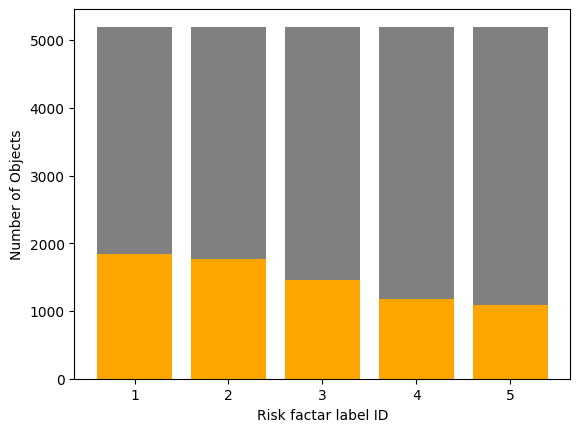

In [23]:
import numpy as np
import matplotlib.pyplot as plt

danger_item_list = []
for one_data in dataset.values():
    
    for one_region_id in range(len(one_data)):
        danger_item = one_data[one_region_id]["risk_focter"]
        danger_item_list.append(eval(danger_item))

class_num = len(danger_item_list[0])

pos_list = (class_num) * [0]
neg_list = (class_num) * [0]

for one_danger_item in danger_item_list:
    if one_danger_item != []:
        
        for class_label in range(class_num):
            if one_danger_item[class_label] == 0:
                neg_list[class_label] += 1
            else:
                pos_list[class_label] += 1
            
print("neg_list",neg_list)
print("pos_list",pos_list)
print("[{}/{} , {}/{} , {}/{} , {}/{} , {}/{}]".format(neg_list[0], pos_list[0], neg_list[1], pos_list[1], neg_list[2], pos_list[2],
                                                       neg_list[3], pos_list[3], neg_list[4], pos_list[4]))
zero_num_index = [i for i, x in enumerate(pos_list) if x == 0]
print("ラベル数が0のインデックスは" + str(zero_num_index))
print("物体数は", len(danger_item_list))
height1 = np.array(pos_list)
height2 = np.array(neg_list)
labels = [1,2,3,4,5]
left = np.arange(0, len(neg_list))

plt.ylabel("Number of Objects")
plt.xlabel("Risk factar label ID")

plt.bar(left, height1, color="orange", tick_label = labels)
plt.bar(left, height2, bottom=height1, color="grey", tick_label = labels)

plt.savefig("./graph_img/under_mample_data_rate.png", format="png", dpi=300)

In [24]:
with open('./dataset/all_dataset.json', 'w') as fp:
    json.dump(dataset, fp, ensure_ascii=False, indent=2)

# 5分割_test_valid_train_split

In [25]:
#split_id作成

import random
import json
import os

all_data = open('./dataset/all_dataset.json', 'r')
all_data = json.load(all_data)

if os.path.isdir("./dataset/split_id_data") == False:
    os.mkdir("./dataset/split_id_data")

img_id = []
for one_img_data in all_data:
    img_id.append(one_img_data)

id_split_list = img_id

# シード値を設定
seed_value = 0
random.seed(seed_value)

# リストをシャッフル
random.shuffle(id_split_list)
print("シャッフル後のimg_idは",id_split_list)
# 5分割
split_size = len(id_split_list) // 5
result = [id_split_list[i * split_size: (i + 1) * split_size] for i in range(5)]#すべてのデータを5分割[[],[],[],[],[]]
print(len(result[2]))
split_position = [[0,1],[1,2],[2,3],[3,4],[4,0]]
for data_label in range(5):

    test_id_list=result[split_position[data_label][0]]
    valid_id_list=result[split_position[data_label][1]]
    train_id_list = [result[i] for i in range(len(result)) if i not in split_position[data_label]]
    train_id_list = [item for sublist in train_id_list for item in sublist]
    
    split_id_data = {"test_id": test_id_list, "valid_id": valid_id_list, "train_id": train_id_list}
    
    with open('./dataset/split_id_data/split_id_data{}.json'.format(data_label + 1), 'w') as fp:
        json.dump(split_id_data, fp, ensure_ascii=False)

シャッフル後のimg_idは ['3511', '142', '1087', '2444', '1628', '1248', '92', '1881', '2024', '1989', '3854', '2904', '2406', '1750', '609', '1482', '112', '2767', '2452', '2145', '2544', '1818', '3726', '1201', '3742', '131', '910', '2061', '2789', '3733', '2098', '2708', '3218', '626', '3924', '2402', '2629', '456', '223', '2600', '3800', '107', '607', '2743', '780', '3170', '3782', '2754', '3690', '3640', '3140', '2665', '333', '1948', '1339', '1900', '2823', '1892', '2354', '1765', '3399', '3907', '1103', '810', '2587', '143', '136', '1450', '3062', '3721', '2603', '2933', '3289', '2548', '2662', '3910', '236', '1612', '1936', '3029', '2630', '282', '207', '3788', '2512', '1674', '1730', '2608', '1789', '268', '3496', '1937', '3702', '3805', '16', '729', '1978', '1283', '104', '782', '3931', '2497', '1216', '303', '3022', '121', '2457', '2595', '1581', '2877', '2692', '2453', '249', '1205', '3535', '129', '3993', '1096', '30', '2383', '2559', '2177', '3543', '1091', '1213', '945', '2958', '

In [27]:
import os


print(len(all_data))

for dala_label in range(5):
    if os.path.isdir("./dataset/split_data{}".format(dala_label + 1)) == False:
        os.mkdir("./dataset/split_data{}".format(dala_label + 1))
    
    id_data = open("./dataset/split_id_data/split_id_data{}.json".format(dala_label + 1), 'r')
    id_data = json.load(id_data)
    
    test_data = {str(key): value for key, value in all_data.items() if key in id_data["test_id"]}
    valid_data = {str(key): value for key, value in all_data.items() if key in id_data["valid_id"]}
    train_data = {str(key): value for key, value in all_data.items() if key in id_data["train_id"]}
    print(test_data)
    with open("./dataset/split_data{}/test_data.json".format(dala_label + 1), 'w') as fp:
        json.dump(test_data, fp, ensure_ascii=False, indent=2)
    with open("./dataset/split_data{}/valid_data.json".format(dala_label + 1), 'w') as fp:
        json.dump(valid_data, fp, ensure_ascii=False, indent=2)
    with open("./dataset/split_data{}/train_data.json".format(dala_label + 1), 'w') as fp:
        json.dump(train_data, fp, ensure_ascii=False, indent=2)
    
    print(id_data)

2135
{'100': [{'image_id': '100', 'xyxy': [540.0, 368.0, 571.0, 458.0], 'conf': 0.685330867767334, 'class': 0, 'risk_focter': '[0, 1, 0, 0, 0]'}], '101': [{'image_id': '101', 'xyxy': [565.0, 313.0, 610.0, 489.0], 'conf': 0.8230834603309631, 'class': 0, 'risk_focter': '[0, 1, 1, 0, 0]'}, {'image_id': '101', 'xyxy': [598.0, 293.0, 820.0, 544.0], 'conf': 0.8196204900741577, 'class': 3, 'risk_focter': '[]'}, {'image_id': '101', 'xyxy': [159.0, 321.0, 268.0, 656.0], 'conf': 0.7910520434379578, 'class': 0, 'risk_focter': '[0, 1, 0, 0, 0]'}], '1015': [{'image_id': '1015', 'xyxy': [647.0, 361.0, 734.0, 424.0], 'conf': 0.8865452408790588, 'class': 1, 'risk_focter': '[0, 0, 0, 0, 0]'}, {'image_id': '1015', 'xyxy': [423.0, 361.0, 518.0, 465.0], 'conf': 0.8638445138931274, 'class': 1, 'risk_focter': '[1, 0, 0, 1, 0]'}, {'image_id': '1015', 'xyxy': [553.0, 360.0, 581.0, 381.0], 'conf': 0.820068359375, 'class': 1, 'risk_focter': '[]'}], '104': [{'image_id': '104', 'xyxy': [923.0, 359.0, 980.0, 511.0

In [29]:
# pos_weightの算出

for data_k in range(5):
    
    train_data = open("./dataset/split_data{}/train_data.json".format(data_k + 1), 'r')
    train_data = json.load(train_data)
    
    danger_item_list = []
    for one_data in train_data.values():

        for one_region_id in range(len(one_data)):
            danger_item = one_data[one_region_id]["risk_focter"]
            danger_item_list.append(eval(danger_item))

    class_num = len(danger_item_list[0])

    pos_list = (class_num) * [0]
    neg_list = (class_num) * [0]

    for one_danger_item in danger_item_list:
        if one_danger_item != []:

            for class_label in range(class_num):
                if one_danger_item[class_label] == 0:
                    neg_list[class_label] += 1
                else:
                    pos_list[class_label] += 1

    #print("neg_list",neg_list)
    #print("pos_list",pos_list)
    print("[{}/{} , {}/{} , {}/{} , {}/{} , {}/{}]".format(neg_list[0], pos_list[0], neg_list[1], pos_list[1], neg_list[2], pos_list[2],
                                                           neg_list[3], pos_list[3], neg_list[4], pos_list[4]))
    zero_num_index = [i for i, x in enumerate(pos_list) if x == 0]
    print("ラベル数が0のインデックスは" + str(zero_num_index))
    print("物体数は", len(danger_item_list))
    height1 = np.array(pos_list)
    height2 = np.array(neg_list)
    labels = [1,2,3,4,5]
    left = np.arange(0, len(neg_list))
    """
    plt.ylabel("Number of Objects")
    plt.xlabel("Risk factar label ID")

    plt.bar(left, height1, color="orange", tick_label = labels)
    plt.bar(left, height2, bottom=height1, color="grey", tick_label = labels)
    """

[1978/1095 , 2060/1013 , 2194/879 , 2366/707 , 2444/629]
ラベル数が0のインデックスは[]
物体数は 6174
[1982/1088 , 2016/1054 , 2193/877 , 2372/698 , 2431/639]
ラベル数が0のインデックスは[]
物体数は 6018
[2046/1120 , 2059/1107 , 2270/896 , 2469/697 , 2478/688]
ラベル数が0のインデックスは[]
物体数は 6128
[2055/1095 , 2059/1091 , 2276/874 , 2455/695 , 2488/662]
ラベル数が0のインデックスは[]
物体数は 6244
[2025/1107 , 2081/1051 , 2266/866 , 2413/719 , 2483/649]
ラベル数が0のインデックスは[]
物体数は 6270


# 訓練データの分布

In [31]:
import json
for dala_label in range(5):
    danger_item_list = []
    data = open("./dataset/split_data{}/train_data.json".format(dala_label + 1), 'r')
    data = json.load(data)
    for one_data in data.values():
        for one_region_id in range(len(one_data)):
            danger_item = one_data[one_region_id]["risk_focter"]
            danger_item_list.append(eval(danger_item))
    print("分割パターン{}の物体数は{}個".format(dala_label + 1,len(danger_item_list)))
    

分割パターン1の物体数は6174個
分割パターン2の物体数は6018個
分割パターン3の物体数は6128個
分割パターン4の物体数は6244個
分割パターン5の物体数は6270個


In [32]:
labels = ['person', 'car', "bus", "track", "traffic_light"]

for dala_label in range(5):
    
    data = open("./dataset/split_data{}/train_data.json".format(dala_label + 1), 'r')
    data = json.load(data)
    
    class_list = [0,0,0,0,0]
    
    for one_data in data.values():

        for one_region_id in range(len(one_data)):
            class_label = one_data[one_region_id]["class"]
            if class_label == 0:
                class_list[0] += 1
            if class_label == 1:
                class_list[1] += 1
            if class_label == 2:
                class_list[2] += 1
            if class_label == 3:
                class_list[3] += 1
            if class_label == 4:
                class_list[4] += 1

    print("分割パターン{}".format(dala_label + 1))
    for i in range(len(labels)):
        print("{}->{}個".format(labels[i],class_list[i]))
    

分割パターン1
person->2413個
car->2227個
bus->201個
track->1186個
traffic_light->147個
分割パターン2
person->2291個
car->2200個
bus->195個
track->1181個
traffic_light->151個
分割パターン3
person->2448個
car->2231個
bus->189個
track->1116個
traffic_light->144個
分割パターン4
person->2511個
car->2261個
bus->191個
track->1128個
traffic_light->153個
分割パターン5
person->2481個
car->2268個
bus->202個
track->1170個
traffic_light->149個


# テストデータの分布

In [33]:
import json
for dala_label in range(5):
    danger_item_list = []
    data = open("./dataset/split_data{}/test_data.json".format(dala_label + 1), 'r')
    data = json.load(data)
    for one_data in data.values():
        for one_region_id in range(len(one_data)):
            danger_item = one_data[one_region_id]["risk_focter"]
            danger_item_list.append(eval(danger_item))
    print("分割パターン{}の物体数は{}個".format(dala_label + 1,len(danger_item_list)))
    

分割パターン1の物体数は1984個
分割パターン2の物体数は2120個
分割パターン3の物体数は2140個
分割パターン4の物体数は2010個
分割パターン5の物体数は2024個


In [34]:
import numpy as np

all_obj_num_list = []
labels = ['person', 'car', "bus", "track", "traffic_light"]

for dala_label in range(5):
    
    data = open("./dataset/split_data{}/test_data.json".format(dala_label + 1), 'r')
    data = json.load(data)
    
    obj_num_list = []
    class_list = [0,0,0,0,0]
    
    for one_data in data.values():
        
        obj_num_list.append(len(one_data))
        
        for one_region_id in range(len(one_data)):
            class_label = one_data[one_region_id]["class"]
            if class_label == 0:
                class_list[0] += 1
            if class_label == 1:
                class_list[1] += 1
            if class_label == 2:
                class_list[2] += 1
            if class_label == 3:
                class_list[3] += 1
            if class_label == 4:
                class_list[4] += 1

    all_obj_num_list.append(obj_num_list)
    
    print("分割パターンの分散{}の分散は{}".format(dala_label+1,np.round(np.var(obj_num_list), decimals=3)))
    
    print("分割パターン{}".format(dala_label + 1))
    for i in range(len(labels)):
        print("{}->{}個".format(labels[i],class_list[i]))
    

分割パターンの分散1の分散は5.821
分割パターン1
person->754個
car->732個
bus->60個
track->382個
traffic_light->56個
分割パターンの分散2の分散は6.619
分割パターン2
person->881個
car->770個
bus->65個
track->359個
traffic_light->45個
分割パターンの分散3の分散は7.426
分割パターン3
person->876個
car->759個
bus->66個
track->387個
traffic_light->52個
分割パターンの分散4の分散は5.697
分割パターン4
person->724個
car->739個
bus->71個
track->424個
traffic_light->52個
分割パターンの分散5の分散は5.827
分割パターン5
person->813個
car->729個
bus->64個
track->375個
traffic_light->43個


# 分割パターンごとのラベル正例負例分布

In [38]:
import json
data_k = 1#分割パターンを選択
data = open("./dataset/split_data{}/test_data.json".format(data_k), 'r')
data = json.load(data)

neg_list [675, 650, 736, 802, 811]
pos_list [348, 373, 287, 221, 212]
[675/348 , 650/373 , 736/287 , 802/221 , 811/212]
ラベル数が0のインデックスは[]
物体数は 1984


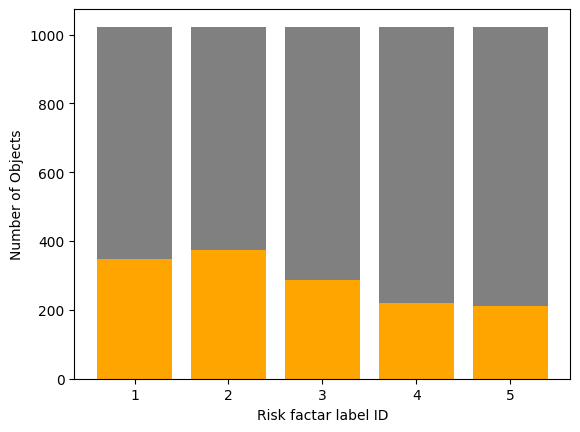

In [39]:
import numpy as np
import matplotlib.pyplot as plt

danger_item_list = []
for one_data in data.values():
    
    for one_region_id in range(len(one_data)):
        danger_item = one_data[one_region_id]["risk_focter"]
        danger_item_list.append(eval(danger_item))

class_num = len(danger_item_list[0])

pos_list = (class_num) * [0]
neg_list = (class_num) * [0]

for one_danger_item in danger_item_list:
    if one_danger_item != []:
        
        for class_label in range(class_num):
            if one_danger_item[class_label] == 0:
                neg_list[class_label] += 1
            else:
                pos_list[class_label] += 1

print("neg_list",neg_list)
print("pos_list",pos_list)
print("[{}/{} , {}/{} , {}/{} , {}/{} , {}/{}]".format(neg_list[0], pos_list[0], neg_list[1], pos_list[1], neg_list[2], pos_list[2],
                                                       neg_list[3], pos_list[3], neg_list[4], pos_list[4]))
zero_num_index = [i for i, x in enumerate(pos_list) if x == 0]
print("ラベル数が0のインデックスは" + str(zero_num_index))
print("物体数は", len(danger_item_list))
height1 = np.array(pos_list)
height2 = np.array(neg_list)
labels = [1,2,3,4,5]
left = np.arange(0, len(neg_list))

plt.ylabel("Number of Objects")
plt.xlabel("Risk factar label ID")

plt.bar(left, height1, color="orange", tick_label = labels)
plt.bar(left, height2, bottom=height1, color="grey", tick_label = labels)

plt.savefig("./graph_img/data_rate{}.png".format(data_k), format="png", dpi=300)

# データセット表示

In [40]:
#データセット表示
import json
import cv2

edit_detect_data_open = open("./dataset/all_dataset.json", 'r')
edit_detect_data_load = json.load(edit_detect_data_open)
font = cv2.FONT_HERSHEY_SIMPLEX
image_path = "./dataset/drama_image"
for k,v in edit_detect_data_load.items():
    print(v)
    imgfile=image_path+'/'+str(k)+'.jpg'
    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.copyMakeBorder(img, 0, 0, 0, 300, cv2.BORDER_CONSTANT, value=[255,255,255])
    for box_id, one_box in enumerate(v):
       
        if all(x == 0 for x in eval(one_box['risk_focter'])):
            
            color = (0,0,255)
        else:
            color = (255,0,0)
        
        risk_list = eval(one_box['risk_focter'])
        
        if all(x == 0 for x in risk_list) == True:
            risk_txt ="no_risk"
        else:
            risk_index = [index + 1 for index, value in enumerate(risk_list) if value != 0]
            risk_txt = str(risk_index)
        cv2.rectangle(img, (int(one_box['xyxy'][0]), int(one_box['xyxy'][1])), (int(one_box['xyxy'][2]), int(one_box['xyxy'][3])), color , 2)
        cv2.putText(img, str(box_id), (int(one_box['xyxy'][0]), int(one_box['xyxy'][1] - 2)), font, 1, (255, 255, 0), thickness=2, lineType=cv2.LINE_AA)
        cv2.putText(img, "id:"+str(box_id), (1025,50 + box_id * 70), font, 0.75, color, thickness=2, lineType=cv2.LINE_AA)
        cv2.putText(img, str(risk_txt), (1100, 50 + box_id * 70), font, 1, color, thickness=2, lineType=cv2.LINE_AA)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite("./dataset/all_dataset_dis/{}.jpg".format(k),img)

[{'image_id': '1', 'xyxy': [707.0, 202.0, 1000.0, 736.0], 'conf': 0.7529627680778503, 'class': 1, 'risk_focter': '[0, 1, 1, 0, 0]'}, {'image_id': '1', 'xyxy': [402.0, 375.0, 426.0, 453.0], 'conf': 0.6277643442153931, 'class': 0, 'risk_focter': '[0, 1, 0, 0, 0]'}]
[{'image_id': '10', 'xyxy': [550.0, 384.0, 589.0, 502.0], 'conf': 0.7884036302566528, 'class': 0, 'risk_focter': '[0, 1, 1, 1, 0]'}, {'image_id': '10', 'xyxy': [618.0, 384.0, 661.0, 506.0], 'conf': 0.7632228136062622, 'class': 0, 'risk_focter': '[0, 1, 1, 1, 0]'}]
[{'image_id': '100', 'xyxy': [540.0, 368.0, 571.0, 458.0], 'conf': 0.685330867767334, 'class': 0, 'risk_focter': '[0, 1, 0, 0, 0]'}]
[{'image_id': '1004', 'xyxy': [620.0, 353.0, 769.0, 494.0], 'conf': 0.8942241668701172, 'class': 1, 'risk_focter': '[0, 0, 0, 0, 0]'}, {'image_id': '1004', 'xyxy': [62.0, 373.0, 84.0, 434.0], 'conf': 0.7765676975250244, 'class': 0, 'risk_focter': '[]'}, {'image_id': '1004', 'xyxy': [129.0, 389.0, 333.0, 542.0], 'conf': 0.774851024150848